Import of libraries

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

plt.style.use("seaborn-v0_8")


Function for data loading

In [19]:
def load_data(tickers, start="2018-01-01"):
    data = yf.download(tickers, start=start)["Close"]
    returns = data.pct_change().dropna()
    return data, returns

Function for market implied returns

In [20]:
def market_implied_returns(cov, market_weights, delta=2.5):
    return delta * cov @ market_weights

Function for BL

In [21]:

def black_litterman(cov, market_weights, P, Q, Omega, tau=0.05, delta=2.5):
    pi = market_implied_returns(cov, market_weights, delta)

    tau_cov_inv = np.linalg.inv(tau * cov)
    omega_inv = np.linalg.inv(Omega)

    middle = tau_cov_inv + P.T @ omega_inv @ P

    mu_bl = np.linalg.inv(middle) @ (
        tau_cov_inv @ pi + P.T @ omega_inv @ Q
    )

    return mu_bl

Portfolio Optimizer

In [22]:

def optimize_portfolio(expected_returns, cov):
    n = len(expected_returns)

    def neg_sharpe(weights):
        ret = weights @ expected_returns
        vol = np.sqrt(weights @ cov @ weights)
        return -ret / vol

    constraints = [{"type": "eq", "fun": lambda w: np.sum(w) - 1}]
    bounds = [(0, 1) for _ in range(n)]
    init = np.ones(n) / n

    result = minimize(neg_sharpe, init,
                      method="SLSQP",
                      bounds=bounds,
                      constraints=constraints)

    return result.x

Function for MC simulation

In [23]:
def monte_carlo_sim(expected_returns, cov, n_sim=5000):
    results = []
    weights_record = []

    n = len(expected_returns)

    for _ in range(n_sim):
        w = np.random.random(n)
        w /= np.sum(w)

        ret = w @ expected_returns
        vol = np.sqrt(w @ cov @ w)
        sharpe = ret / vol

        results.append([ret, vol, sharpe])
        weights_record.append(w)

    return np.array(results), np.array(weights_record)

Function for portfolio performance backtesting

In [24]:
def portfolio_performance(weights, returns):
    portfolio_returns = returns @ weights
    cumulative = (1 + portfolio_returns).cumprod()
    return cumulative

C:\Users\erick\AppData\Local\Temp\ipykernel_20128\2812864340.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start)["Close"]
[*********************100%***********************]  5 of 5 completed
C:\Users\erick\AppData\Local\Temp\ipykernel_20128\2812864340.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


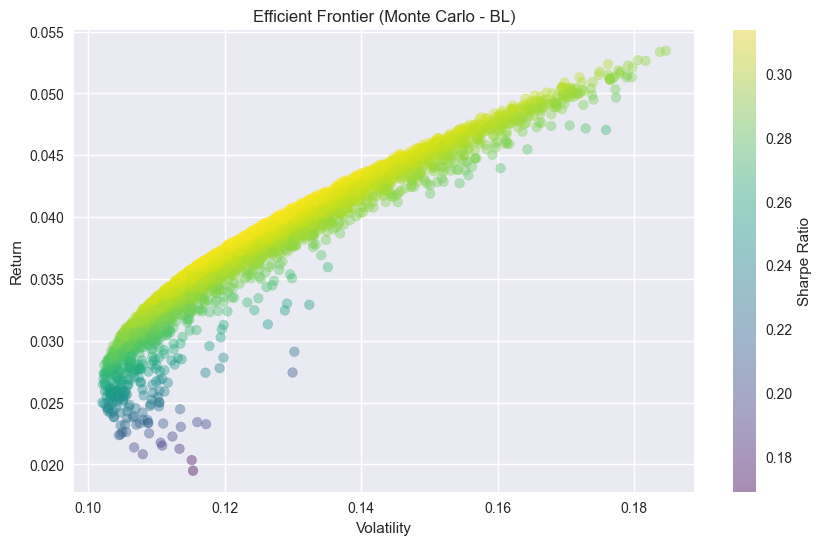


Portfolio Weights:
     Equal Weight  Mean-Variance  Black-Litterman
SPY           0.2   9.658973e-17         0.345550
EFA           0.2   5.118968e-17         0.054155
EEM           0.2   6.447133e-01         0.199852
TLT           0.2   3.552867e-01         0.200208
GLD           0.2   0.000000e+00         0.200234


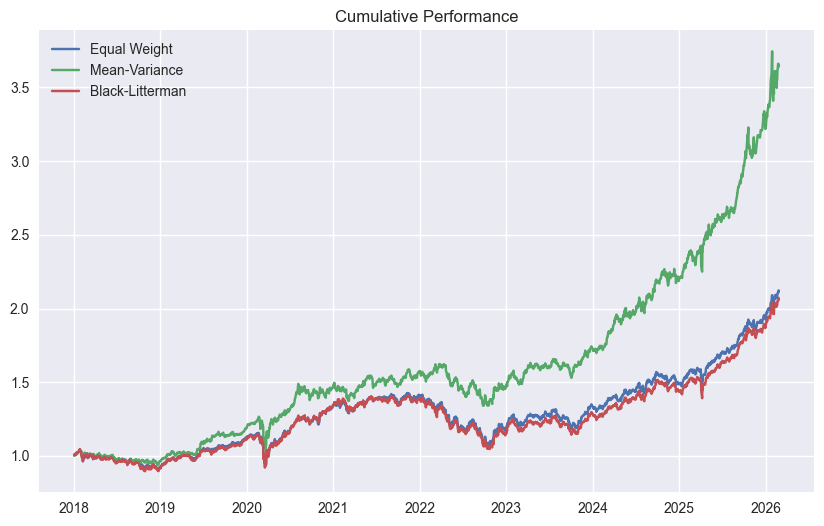

In [25]:
tickers = ["SPY", "EFA", "EEM", "TLT", "GLD"]
data, returns = load_data(tickers)

cov = returns.cov() * 252
mean_returns = returns.mean() * 252

# Market weights (proxy equal weight here)
market_weights = np.ones(len(tickers)) / len(tickers)


# Investor Views

# View 1: SPY will outperform EFA by 3%
P = np.array([
    [1, -1, 0, 0, 0]
])

Q = np.array([0.03])

Omega = np.array([[0.0025]])


# Black-Litterman

mu_bl = black_litterman(cov.values,
                        market_weights,
                        P,
                        Q,
                        Omega)

    
# Optimization
 
w_mvo = optimize_portfolio(mean_returns.values, cov.values)
w_bl = optimize_portfolio(mu_bl, cov.values)
w_eq = np.ones(len(tickers)) / len(tickers)


# Monte Carlo
    
mc_results, mc_weights = monte_carlo_sim(mu_bl, cov.values)

    
# VISUALIZATION
    

plt.figure(figsize=(10, 6))
plt.scatter(mc_results[:,1], mc_results[:,0],
                c=mc_results[:,2], cmap="viridis", alpha=0.4)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.title("Efficient Frontier (Monte Carlo - BL)")
plt.show()

    
# Weight Comparison
    
weights_df = pd.DataFrame({
    "Equal Weight": w_eq,
    "Mean-Variance": w_mvo,
    "Black-Litterman": w_bl
}, index=tickers)

print("\nPortfolio Weights:")
print(weights_df)

    
# Backtest
    
perf_eq = portfolio_performance(w_eq, returns)
perf_mvo = portfolio_performance(w_mvo, returns)
perf_bl = portfolio_performance(w_bl, returns)

plt.figure(figsize=(10, 6))
plt.plot(perf_eq, label="Equal Weight")
plt.plot(perf_mvo, label="Mean-Variance")
plt.plot(perf_bl, label="Black-Litterman")
plt.legend()
plt.title("Cumulative Performance")
plt.show()